In [1]:
%matplotlib inline

In [2]:
import numpy as np
from qreservoirpy import QReservoir, Layers
from qiskit.quantum_info import random_clifford


In [3]:
n_qubits = 10
shots = 10000
op = random_clifford(n_qubits, )

In [4]:
target = [0, 0, 0, 1] * 30
def build_method(circ, timestep, operator, encoder):
    circ.unitary(operator, circ.qubits)
    circ.measure(0)
    circ.initialize(encoder[timestep], [0])
    return circ

res = QReservoir(
    qubits=n_qubits, 
    layers=[
        Layers.H(),
        Layers.Timeseries(build_method=build_method),
    ], 
    operator=op, 
    encoder={
        0: '0',
        1: '1',  
    })
mean = res.run(target, shots=shots, transpile=True, simulator='aer_simulator_stabilizer')
res.circuit.draw('mpl')


  0%|          | 0/120 [00:00<?, ?it/s]

(120, 1)


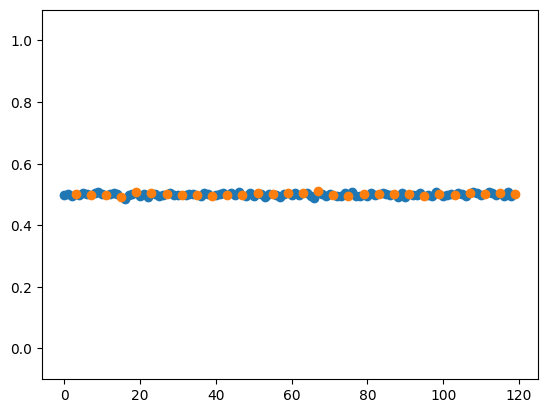

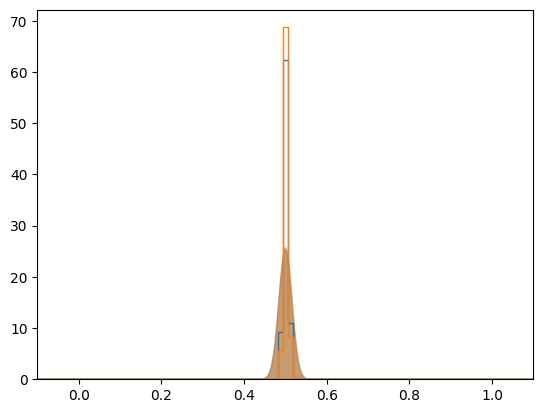

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
print(mean.shape)
plt.figure()
for t in np.unique(target):
    mask = t==target
    plt.plot(np.arange(len(mean))[mask], mean[mask], marker='o', lw=0)
plt.ylim(-0.1, 1.1)
plt.show()

x_plot = np.linspace(-0.5, 1.5, 10000, endpoint=True)

plt.figure()
for i, t in enumerate(np.unique(target)):
    color = 'C'+str(i)
    mask = t==target
    plt.hist(mean[mask], density=True, bins=np.linspace(-0.1, 1.1, 100, endpoint=True),
             histtype='step', color=color)
    kde = KernelDensity(bandwidth=1.5e-2, kernel='gaussian')
    kde.fit(mean[mask].reshape(-1, 1))
    logprob = kde.score_samples(x_plot.reshape(-1, 1))
    plt.fill_between(x_plot, np.exp(logprob), alpha=0.5, color=color)
    
plt.xlim(-0.1, 1.1)
plt.show()

In [ ]:
x = mean.reshape(-1, 1)
y = target

warmup = 20
x = x[warmup:]
y = y[warmup:]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7878787878787878